# 利用Self-Attention实现Transformer编码器

上节课讲到了Multi-Head Self-Attention的实现，并利用Multi-Head Self-Attention实现了时间序列分析。

今天讲解如何利用Self-Attention构建Transformer编码器。

## 1. Transformer编码器架构预览

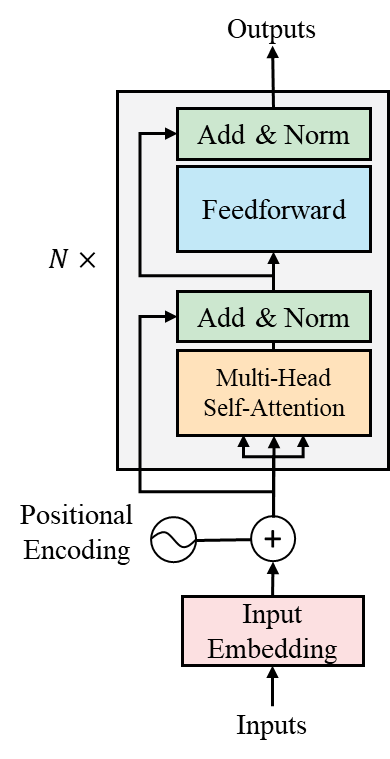

## 2. Input Embedding: 单词到向量的映射

给定长度为$N$的句子$S=(w_1,w_2,\cdots,w_N)$，其中$w_i$是一个单词（中文汉字）。

定义单词到向量的映射函数为$f_e$，其接收单词$w_i$作为输入，输出单词对应的词向量$v_i\in\mathbb{R}^d$，其中$d$为一个词向量的长度。

$$
v_i=f_e(w_i)
$$

单词$w_i$是文本，怎么可能被函数作为输入映射成向量？

### 2.1 词表

我们可以引入一个词表$\mathcal{V}$，其中包含所有可能出现的单词：

```txt
I
machine
love
learning
...
```

上述词表中，第1个单词为I，说明I这个单词的索引为1，我们可以用数字1表示I这个单词。

依此类推，只要单词$w_i$在词表，我们就一定可以用一个整数$x_i$来表示单词$w_i$。我们将这个过程用函数$f_v$表示：

$$
x_i = f_v(w_i)
$$

### 2.2 向量表

我们再引入一个向量表，它的长度和词表$\mathcal{V}$一样，但是每一行是一个向量，这个向量就用来表示词表中对应行的单词，称这个向量为词向量：

```python
[0.1, 0.2, 0.3]
[0.4, 0.3, 0.2]
[0.3, 0.2, 0.1]
[0.2, 0.2, 0.4]
...
```

这个向量表可以表示成一个矩阵$W^e\in\mathbb{R}^{|\mathcal{V}|\times d}$，其中$d$是每个词向量的长度。

在开始训练词向量之前，$W^e$是随机初始化的，即每一个词向量都是随机的值。

### 2.3 嵌入函数

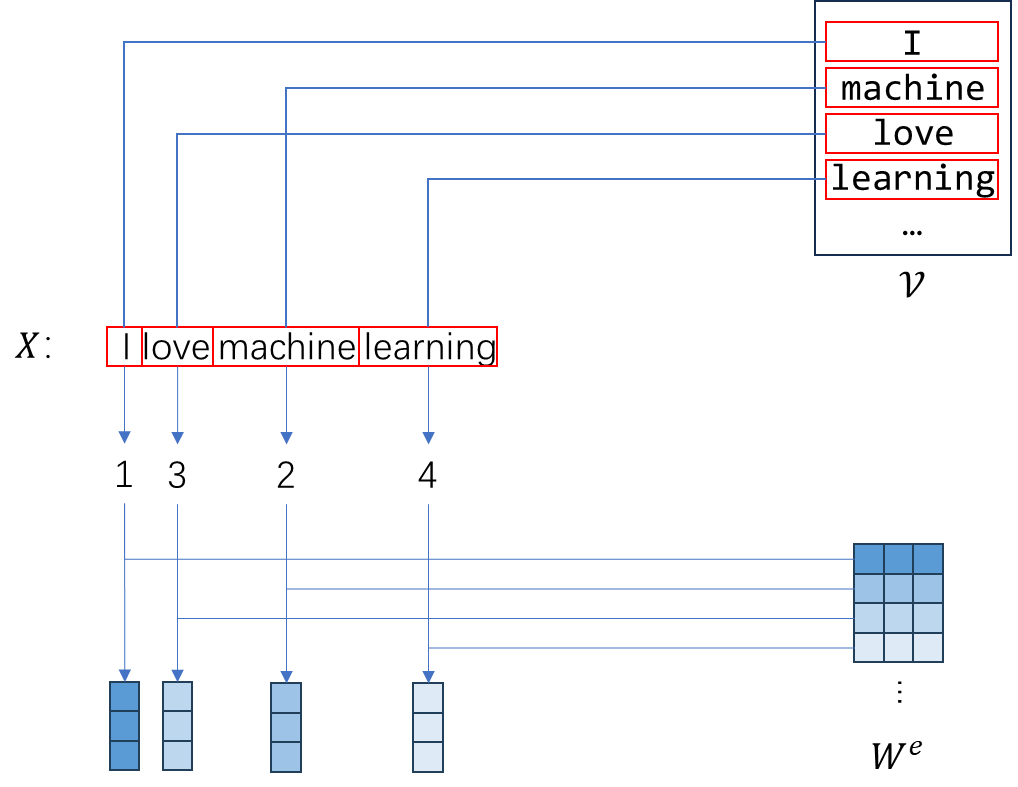

给定一个单词$w_i$在词表中的索引$x_i$，它的词向量$\mathbf{x}^e_i$可以表示为：

$$
\mathbf{x}^e_i=f_e(w_i)=W^e_{[x_i,:]}
$$

其中$W^e_{[x_i,:]}$表示矩阵$W^e$中的第$x_i$行。$W^e$是需要训练的参数。

我们称$f_e$为词嵌入函数，可以用pytorch中的嵌入层`nn.Embedding`来表达$f_e$：

In [ ]:
import torch

from torch import nn

In [ ]:
fe = nn.Embedding(8, 3)  # 8表示词表大小，即矩阵W^e的行数，3表示词向量长度，即矩阵W^e的列数

可以看一下`fe`的参数，是一个8x3大小的矩阵，对应上面所述的$W^e$：

In [ ]:
fe.weight

Parameter containing:
tensor([[-0.6522,  0.9067, -0.5167],
        [-0.4601, -1.5218, -0.6675],
        [-1.0666,  0.0398, -1.1635],
        [ 0.8926, -0.3398, -0.8512],
        [ 0.2979,  0.2080,  1.1065],
        [ 0.1370, -0.4456,  3.5492],
        [ 0.3797,  0.2251,  0.7678],
        [-1.3104,  0.3256, -0.4771]], requires_grad=True)

假设我们有如下词表：

In [ ]:
vocab = [
  "I",
  "machine",
  "love",
  "learning",
  "course",
  "like",
  "useful",
  "with"
]

对于单词“machine”，我们可以利用`fe`计算它的词向量

In [ ]:
x = vocab.index("machine")  # 1
vector = fe(torch.LongTensor([x]))[0]

In [ ]:
vector

tensor([-0.4601, -1.5218, -0.6675], grad_fn=<SelectBackward0>)

单词“machine”的词向量就等于`fe`中参数矩阵对应行的向量：

In [ ]:
fe.weight[x]

tensor([-0.4601, -1.5218, -0.6675], grad_fn=<SelectBackward0>)

In [ ]:
fe.weight[x] == vector

tensor([True, True, True])

对于句子“I love learning useful machine learning course”，可以对每个词计算词向量，形成一个向量序列：

In [ ]:
sentence = "I love learning useful machine learning course"

def tokenize(sentence, vocab):
  X = []
  for word in sentence.split():
    X.append(vocab.index(word))
  return X

X = tokenize(sentence, vocab)
X

[0, 2, 3, 6, 1, 3, 4]

In [ ]:
vectors = fe(torch.LongTensor(X))
vectors

tensor([[-0.6522,  0.9067, -0.5167],
        [-1.0666,  0.0398, -1.1635],
        [ 0.8926, -0.3398, -0.8512],
        [ 0.3797,  0.2251,  0.7678],
        [-0.4601, -1.5218, -0.6675],
        [ 0.8926, -0.3398, -0.8512],
        [ 0.2979,  0.2080,  1.1065]], grad_fn=<EmbeddingBackward0>)

## 3. Positional Encoding: 位置编码

原始Transformer使用sin和cos函数实现位置编码的计算。

然而，实践中更常见的方式是使用**可训练的位置编码**。

我们可以使用一个与词嵌入函数$f_e$类似的位置嵌入函数$f_p$，它可以将表示位置的整数映射为一个向量：

$$
\mathbf{x}^p_i = f_p(i)=W^p_{[i,:]}
$$

其中$W^p_{[i,:]}$表示矩阵$W^p$中的第$i$行。$W^p$是需要训练的参数。

然后，词向量$\mathbf{x}^e_i$和位置编码向量$\mathbf{x}^p_i$加起来得到的结果，就是单词$w_i$映射为向量的最终结果$\mathbf{x}_i$：

$$
\mathbf{x}_i=\mathbf{x}^e_i+\mathbf{x}^p_i
$$

## 4. Input Embedding + Positional Encoding

总结来看，对于一个句子$S=(w_1,w_2,\cdots,w_n)$，我们首先利用词表将句子映射为整数索引$X=(x_1,x_2,\cdots,x_n)$：

$$
X=f_v(S)
$$

然后将整数索引$X=(x_1,x_2,\cdots,x_n)$映射为词向量$(\mathbf{x}^e_1,\mathbf{x}^e_2,\cdots,\mathbf{x}^e_n)$：

$$
(\mathbf{x}^e_1,\mathbf{x}^e_2,\cdots,\mathbf{x}^e_n)=f_e(X)=(W^e_{[x_1,:]},W^e_{[x_2,:]},\cdots,W^e_{[x_n,:]})
$$

接下来将句子$X$对应的位置序列$(1,2,\cdots,n)$映射为位置编码向量$(\mathbf{x}^p_1,\mathbf{x}^p_2,\cdots,\mathbf{x}^p_n)$：

$$
(\mathbf{x}^p_1,\mathbf{x}^p_2,\cdots,\mathbf{x}^p_n)=f_p((1,2,\cdots,n))=(W^p_{[1,:]},W^p_{[2,:]},\cdots,W^p_{[n,:]})
$$

最后将词向量与位置编码向量加起来，得到带位置信息的词向量：

$$
\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\cdots,\mathbf{x}_n)=(\mathbf{x}^e_1,\mathbf{x}^e_2,\cdots,\mathbf{x}^e_n)+(\mathbf{x}^p_1,\mathbf{x}^p_2,\cdots,\mathbf{x}^p_n)
$$

因此，给定句子对应的索引序列$X$，其带位置信息的词向量序列$\mathbf{X}$可以表示为：

$$
\begin{aligned}
\mathbf{X}&=f_e(X)+f_p((1,2,\cdots,|X|)) \\
&=(\mathbf{x}^e_1+\mathbf{x}^p_1,\mathbf{x}^e_2+\mathbf{x}^p_2,\cdots,\mathbf{x}^e_{|X|}+\mathbf{x}^p_{|X|}) \\
&=(W^e_{[x_1,:]}+W^p_{[1,:]},W^e_{[x_2,:]}+W^p_{[2,:]},\cdots,W^e_{[x_{|X|},:]}+W^p_{[|X|,:]})
\end{aligned}
$$

这样一来，每个单词都被表示成了参数矩阵$W^e$中的某一行与参数矩阵$W^p$中的某一行的和。

换言之，每个单词都被表示成了一个可学习的向量。

这个过程可以用如下代码实现：

In [ ]:
class TransformerEmbedding(nn.Module):

  def __init__(self, hidden_size, vocab_size, max_length):
    """
    - hidden_size: 每个词所需要表示成的向量的长度
    - vocab_size: 词表大小
    - max_length: 句子的最大长度
    """
    super().__init__()
    self.word_embedding = nn.Embedding(vocab_size, hidden_size)
    self.position_embedding = nn.Embedding(max_length, hidden_size)

  def forward(self, X):
    word_vectors = self.word_embedding(X)
    position_vectors = self.position_embedding(torch.arange(X.shape[1]))
    return word_vectors + position_vectors

我们称`TransformerEmbedding`为Transformer的嵌入模块，包含了词嵌入和位置编码的功能。

我们拿一个开源语言模型的分词器和词表来测试一下上面的代码

In [ ]:
!pip install transformers

载入bart-base模型的分词器

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

这个分词器中包含了一个词表，这个词表是一个字典，Key为单词（token），Value为单词对应的整数索引：

In [ ]:
tokenizer.vocab

{'kill': 16424,
 'Ġstudios': 14991,
 '------': 44516,
 'chant': 40805,
 'Ġsegregation': 24465,
 'Thomas': 25089,
 'ĠHistorically': 29660,
 'als': 1536,
 'ĠFay': 13066,
 'Ġportraying': 28223,
 'ĠLent': 30774,
 'asure': 24669,
 'Ġautomated': 11554,
 'ĠGive': 12192,
 "['": 48759,
 'Bring': 34306,
 'Changing': 44818,
 'itance': 45172,
 'uliffe': 49256,
 'Ġleng': 34583,
 'cci': 12870,
 'ĠBear': 9784,
 'ĠCait': 18901,
 'Ġcheck': 1649,
 'ĠPAL': 28889,
 'ĠCAR': 11903,
 'ĠRonald': 9317,
 'ĠSpeech': 27242,
 'raphic': 32157,
 'Ġmosquitoes': 24994,
 'Making': 31845,
 'OTHER': 30991,
 'ĠNational': 496,
 'Ġcitrus': 28460,
 'aries': 5119,
 'Mom': 29390,
 'irus': 19473,
 'untary': 36710,
 'ĠKnowledge': 27831,
 'itz': 4494,
 'ĠBombs': 42263,
 'Ġcontingency': 24584,
 'Smith': 14124,
 'Ġ265': 26022,
 'Ġoven': 12941,
 'ĠLeague': 815,
 'ĠThornton': 18314,
 'mans': 18370,
 'ĠIcon': 12555,
 'ĠAngeles': 1422,
 'Ġconced': 24647,
 'ĠJoel': 8966,
 'Ġequity': 2355,
 'ĠChips': 39081,
 'Ġcomics': 19453,
 'Ġratified

然后我们可以利用`tokenizer`将句子映射为整数索引序列：

In [ ]:
sentence = "I love learning useful machine learning course"
input_ids = tokenizer(sentence, return_tensors="pt")["input_ids"]

In [ ]:
input_ids

tensor([[   0,  100,  657, 2239, 5616, 3563, 2239,  768,    2]])

然后我们根据词表大小定义一个嵌入模型：

In [ ]:
tokenizer.vocab_size

50265

In [ ]:
embedding_model = TransformerEmbedding(
  hidden_size=3,  # 词向量长度为3
  vocab_size=len(tokenizer.vocab),  # 词表大小为50265
  max_length=16,  # 句子最大长度为16
)

In [ ]:
vectors = embedding_model(input_ids)

In [ ]:
vectors

tensor([[[ 1.5428,  0.5028,  1.4854],
         [ 1.4849,  0.0545, -1.5367],
         [ 0.2073, -0.7479, -0.2019],
         [-0.5746,  2.2821,  0.8826],
         [ 0.0997, -2.3169, -0.3279],
         [-0.1299, -0.9823,  0.3563],
         [ 1.3264,  0.7326,  0.9610],
         [ 0.2656,  0.2032, -0.4452],
         [-1.8376,  1.4678, -1.5470]]], grad_fn=<AddBackward0>)

可以用代码验证，第$i$个单词对应的向量，等于`word_embedding`参数矩阵的第$x_i$行，加上`position_embedding`参数矩阵的第`i`行

In [ ]:
i = 3
xi = input_ids[0, i]

In [ ]:
xi

tensor(2239)

In [ ]:
vector_i = vectors[0, i]

In [ ]:
vector_i  # 第i个单词对应的向量

tensor([-0.5746,  2.2821,  0.8826], grad_fn=<SelectBackward0>)

In [ ]:
# `word_embedding`参数矩阵的第xi行 + `position_embedding`参数矩阵的第i行
embedding_model.word_embedding.weight[xi] + embedding_model.position_embedding.weight[i]

tensor([-0.5746,  2.2821,  0.8826], grad_fn=<AddBackward0>)

In [ ]:
vector_i == embedding_model.word_embedding.weight[xi] + embedding_model.position_embedding.weight[i]

tensor([True, True, True])

## 组合各模块形成Transformer编码器

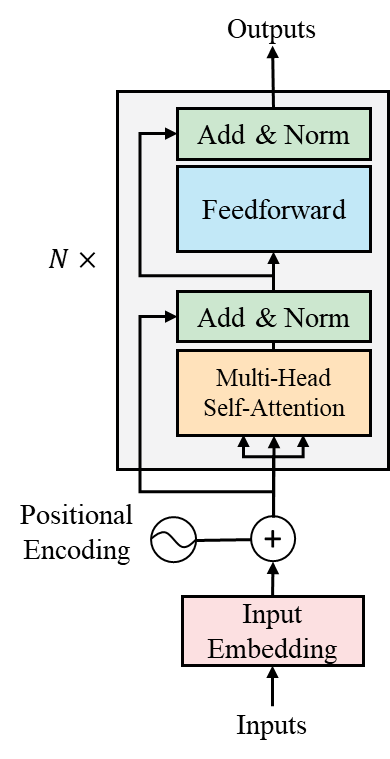

先从上节课的Notebook[多头Self-Attention实现及训练](https://colab.research.google.com/drive/1ZE_NpMP_nyGplITj7DKXjdWgqIonmnpU)中把Multi-Head Self-Attention的实现代码拷贝过来：

In [ ]:
class MultiHeadSelfAttention(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()

    # 保证头数整除向量维度
    assert hidden_size % num_heads == 0

    self.hidden_size = hidden_size
    self.num_heads = num_heads

    self.W_q = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_k = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_v = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)
    self.W_o = nn.Parameter(torch.randn(hidden_size, hidden_size) / 100)

    self.softmax = nn.Softmax(-1)

  def get_attention_mask_2d(self, attention_mask):
    batch_size = attention_mask.size(0)
    mask_len = attention_mask.size(1)
    attention_mask_2d = attention_mask[:, None, None, :].expand(batch_size, self.num_heads, mask_len, mask_len).to(torch.float32)
    inverted_mask = 1.0 - attention_mask_2d
    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(torch.float32).min)

  def forward(self, X, attention_mask):
    Q_m = X @ self.W_q
    K_m = X @ self.W_k
    V_m = X @ self.W_v

    d_m = self.hidden_size // self.num_heads  # d/m

    Q_m_stack = Q_m.view(-1, self.num_heads, Q_m.size(1), d_m)
    K_m_stack = K_m.view(-1, self.num_heads, K_m.size(1), d_m)
    V_m_stack = V_m.view(-1, self.num_heads, V_m.size(1), d_m)

    mask = self.get_attention_mask_2d(attention_mask)
    A_m_stack = self.softmax(Q_m_stack @ K_m_stack.transpose(2, 3) + mask)
    H_m_stack = A_m_stack @ V_m_stack

    H = H_m_stack.view(-1, X.size(1), self.hidden_size)

    H_prime = H @ self.W_o
    return H_prime

灰色模块按照顺序包含1. Multi-Head Self-Attention、2. Add&Norm、3. Feedforward（全连接网络）、和4. 最后一层Add&Norm

我们将灰色模块封装成一个类，名为`EncoderBlock`，表示编码器的一个块（最后的编码器需要多个块堆叠起来）：

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2):
    super().__init__()
    self.attn = MultiHeadSelfAttention(hidden_size, num_heads)
    self.layer_norm1 = nn.LayerNorm(hidden_size)
    self.fnn = nn.Sequential(
      nn.Linear(hidden_size, hidden_size * 4),
      nn.Linear(hidden_size * 4, hidden_size)
    )
    self.layer_norm2 = nn.LayerNorm(hidden_size)

  def forward(self, X, attention_mask):
    H = self.attn(X, attention_mask) + X  # 1
    H = self.layer_norm1(H)  # 2
    H = self.fnn(H) + H  # 3
    H = self.layer_norm2(H)  # 4
    return H

最后封装一个`Encoder`类，包含`TransformerEmbedding`（Input Embedding和Positional Encoding）和多个堆叠的`EncoderBlock`：

In [ ]:
class Encoder(nn.Module):

  def __init__(self, hidden_size=6, num_heads=2, num_blocks=2, vocab_size=1024, max_length=1024):
    super().__init__()
    self.embedding = TransformerEmbedding(hidden_size, vocab_size, max_length)
    self.blocks = nn.ModuleList([EncoderBlock(hidden_size, num_heads) for _ in range(num_blocks)])

  def forward(self, X, attention_mask):
    X = self.embedding(X)
    for block in self.blocks:
      X = block(X, attention_mask)
    return X

以下是定义一个输入输出向量长度为`768`、注意力头数为12、编码器层数为12、句子最大长度（最大位置）为512、以及指定词表长度的Transformer编码器：

In [ ]:
encoder = Encoder(
  hidden_size=768,
  num_heads=12,
  num_blocks=12,
  vocab_size=tokenizer.vocab_size,
  max_length=512,
)

事实上，上述编码器的超参数配置与BERT模型相同。

BERT模型只用到了Transformer的编码器部分，没有用到解码器部分。

BERT通常被用来做句子分类任务。

虽然我们现在有办法定义出BERT模型的结构，但是我们没有办法训练它，因为它太大了，它有1.2亿个参数：

In [ ]:
sum(p.numel() for p in encoder.parameters())

124014336

如果要拿它来做句子分类任务，必须先在大量语料上进行**预训练（pre-training）**，然后在具体的句子分类上做**微调训练（fine-tuning）**

下节课我们会讲：

- BERT的预训练目标
- BERT的模型架构及其与原始Transformer编码器架构的细微区别
- BERT的微调